# Machine Learning with Koalas and Spark

Most of the data scientists or machine learning engineers start with Pandas and Numpy before moving to other libraries. No once can debate around the use of Pandas as a standard data processing library. There are a lot of benefits of using Pandas however one key bottleneck of Pandas API to adapt with distributed processing. Solutions like Modin and Dask solve this problem to some extent. 


When it comes to using distributed processing frameworks, Spark is the de-facto choice for professionals and large data processing hubs. Recently, Databricks's team open-sourced a library called [Koalas](https://koalas.readthedocs.io/en/latest/?badge=latest) to implemented the Pandas API with spark backend. This library is under active development and covering more than 60% of Pandas API. To read more about using Koalas, refer to my earlier article [Spark-ifying Pandas: Databrick’s Koalas with Google Colab](https://medium.com/analytics-vidhya/spark-ifying-pandas-databricks-koalas-with-google-colab-93028890db5).

In this tutorial, I will walk you through to perform exploratory data analysis using Koalas and PySpark to build a regression model using the Spark distributed framework. There are a lot of benefits of using Koalas instead of Pandas API when dealing with large datasets. Some of the key points are

1. Big data processing made easy
2. Quick transformation from Pandas to Koalas
3. Integration with PySpark is seamless

The objective of this tutorial is to leverage the Spark backend for a complete machine learning development cycle using Koalas. The working google collaboratory will be embedded.


# Setting up Spark 3.0.1 in the Google Colaboratory

As a first step, I configure the google colab runtime with spark installation. For details, readers may read my article [Getting Started Spark 3.0.0 in Google Colab](https://medium.com/analytics-vidhya/getting-started-spark3-0-0-with-google-colab-9796d350d78) om medium. 

We will install below programs

* Java 8
* spark-3.0.1
* Hadoop3.2 
* [Findspark](https://github.com/minrk/findspark)

you can install the LATEST version of Spark using below set of commands.

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

## Environment Variable 
After installing the spark and Java, set the environment variables where Spark and Java are installed.

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

## Spark Installation test
Lets test the installation of spark in our google colab environment. 

In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()
# Test the spark 
df = spark.createDataFrame([{"hello": "world"} for x in range(1000)])

df.show(3, False)



+-----+
|hello|
+-----+
|world|
|world|
|world|
+-----+
only showing top 3 rows



## Install Koalas

After installing spark and making sure, it is working, we can now install the databrick's Koalas using pip. 


In [4]:
!pip install koalas


In [5]:
# Install compatible version of pyarrow
!pip install --upgrade pyarrow

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.7/dist-packages (4.0.0)


In [6]:
import seaborn as sns

In [7]:
import databricks.koalas as ks
PYARROW_IGNORE_TIMEZONE = 1

# Machine Learning Development Cycle

The standard practice for developing machine learning models is to perform the exploratory data analysis, perform feature engineering, and build a model. I will try to touch basis on the above point using Koalas. I believe most of the ML engineers/scientists use Pandas API to perform EDA and Feature engineering. I demonstrate the use of Koalas to do the job and use PySpark to build the model.


I will use the [Combined Cycle Power Plant](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant) data set to predict the net hourly electrical output (EP). I have uploaded the data to my [GitHub](https://raw.githubusercontent.com/amjadraza/blogs-data/master/spark_ml/ccpp.csv) so that users can reproduce the results.


## Exploratory Data Analysis using Koalas

As a first step, I want to explore the given data, its distribution, and dependency using Koalas API. I will include a simple example to demonstrate the idea, users can extend it for the problem in-hand.


Download the data and saved it locally

In [8]:
# Downloading the clustering dataset
!wget -q 'https://raw.githubusercontent.com/amjadraza/blogs-data/master/spark_ml/ccpp.csv'

Read the data using Koalas `read_csv` method. To read more about the API follow the [Koalas official documentation](https://koalas.readthedocs.io/en/latest/?badge=latest) 

In [9]:
# Read the iris data
kdf_ccpp = ks.read_csv("ccpp.csv")

In [10]:
kdf_ccpp.columns

Index(['AT', 'V', 'AP', 'RH', 'PE'], dtype='object')

In [11]:
kdf_ccpp.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Just like Pandas, Koalas has feature to plot data to understand the variables. In the below example, I plotted the original data and smoother versions of it. This example demonstrates the use of `plot` and `rolling` window methods 

In [12]:
pip install --upgrade plotly

Requirement already up-to-date: plotly in /usr/local/lib/python3.7/dist-packages (4.14.3)


In [35]:
kdf_ccpp.plot()

In [39]:
# kdf_ccpp['AT'].plot(figsize=(12,6))
# kdf_ccpp['AT'].rolling(window=20).mean().plot()
kdf_ccpp['AT'].rolling(window=200).mean().plot()

Just like above plotting, user can plot all the columns. See below command

In [41]:
# kdf_ccpp.plot(var_layout)

Plotting the all columns using moving average of 20 data points.

In [43]:
kdf_ccpp.rolling(window=20).mean().plot()

Below command is to demonstrate the use of `describe` method similar as in Pandas API.

In [44]:
kdf_ccpp.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.320000,439.750000
50%,20.340000,52.080000,1012.940000,74.960000,451.510000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


## Feature Engineering

The feature engineering step usually comes in junction with EDA and users prepare the features with an objective to be most predictive and nicely distributed. In this article, I will demonstrate the use of Koalas to perform feature engineering.

To understand the relationship between different variables, paiprplot function seaborn is widely used. Use the below command to plot the pairplots of variables in the dataset. Since Seaborn does not support the Koala dataframe, users have to convert it into a pandas dataframe before calling pairplot.  

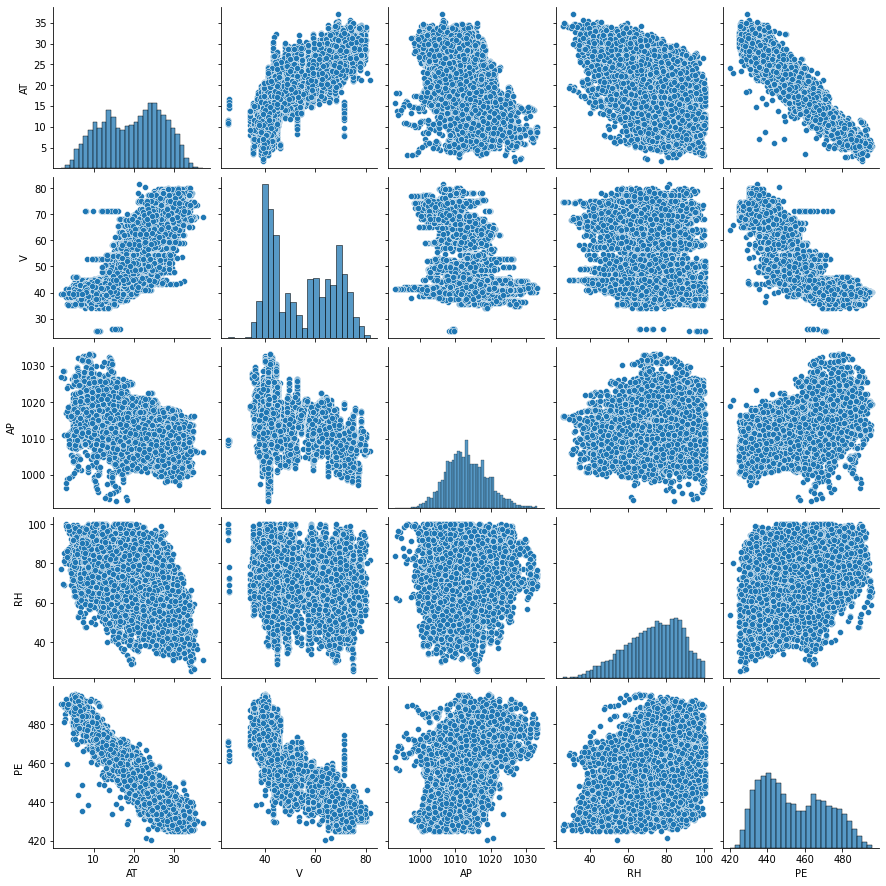

In [45]:
sns.pairplot(kdf_ccpp.to_pandas())

By looking at the above figure, we can see a lot of outliers and for some variable relationship with Target is not clear. To remove the outliers, the simplest solution is to calculate the moving average and I demonstrate that using Koalas.

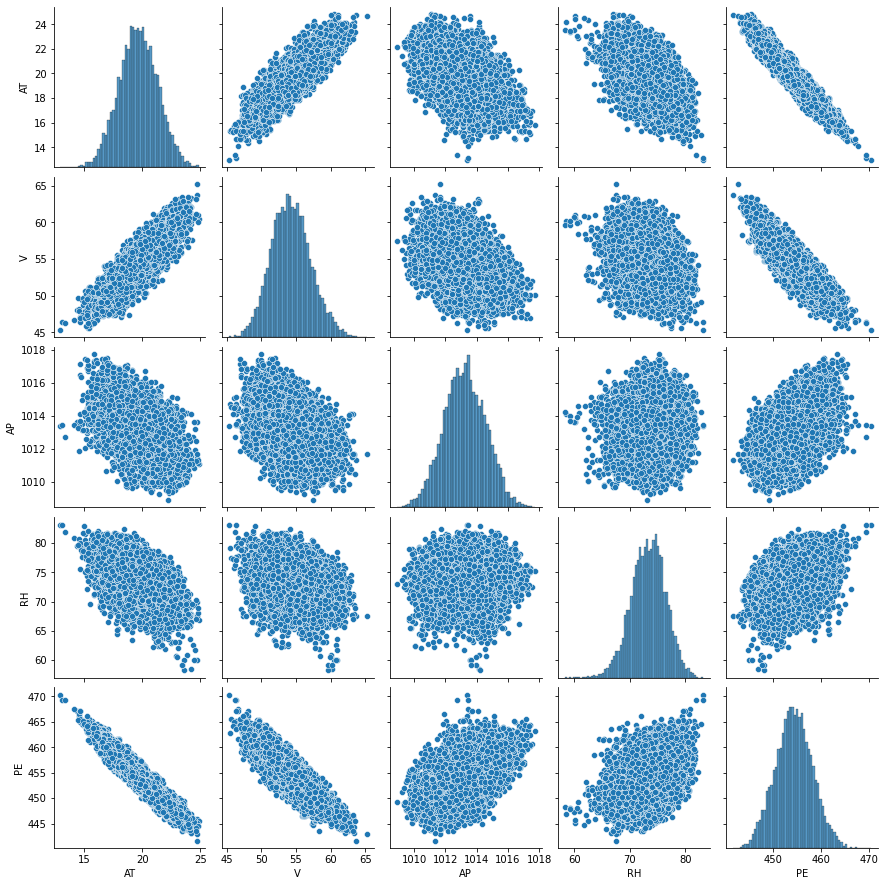

In [46]:
sns.pairplot(kdf_ccpp.rolling(window=20).mean().to_pandas())

Looks like 20 day moving average has better relationship with the Target variable hence using the 20 day average features makes more sense. 

## Model Building using PySpark

Once the EDA and Feature engineering done, it is time to build the predictive model. One of the benefits of using the Koalas dataframe is that users can create a Spark dataframe seamlessly. In the below section, I demonstrate the use of PySpark API to build and train Gradient Boosting Machines (GBM).

In [47]:
# Create the moving average features
kdf = kdf_ccpp.rolling(window=20, min_periods=1).mean()

In [48]:
# Convert the Koalas DataFrame into Spark DataFrame
sdf = kdf.to_spark()

In [49]:
sdf.show(5,True)

+------------------+------+------------------+-----------------+-----------------+
|                AT|     V|                AP|               RH|               PE|
+------------------+------+------------------+-----------------+-----------------+
|             14.96| 41.76|           1024.07|            73.17|           463.26|
|             20.07| 52.36|          1022.055|           66.125|          453.815|
|15.083333333333334| 48.04|1018.7566666666667|74.79666666666667|465.3966666666667|
|           16.5275| 50.36|         1016.6275|          75.2575|         460.6675|
|15.386000000000001|47.788|1015.1479999999999|            79.53|          463.314|
+------------------+------+------------------+-----------------+-----------------+
only showing top 5 rows



In [50]:
sdf.show(5,False)

+------------------+------+------------------+-----------------+-----------------+
|AT                |V     |AP                |RH               |PE               |
+------------------+------+------------------+-----------------+-----------------+
|14.96             |41.76 |1024.07           |73.17            |463.26           |
|20.07             |52.36 |1022.055          |66.125           |453.815          |
|15.083333333333334|48.04 |1018.7566666666667|74.79666666666667|465.3966666666667|
|16.5275           |50.36 |1016.6275         |75.2575          |460.6675         |
|15.386000000000001|47.788|1015.1479999999999|79.53            |463.314          |
+------------------+------+------------------+-----------------+-----------------+
only showing top 5 rows



Now, build the model using PySpark API. For moe details on building models using PySpark refer to my article [Machine Learning With Spark](https://towardsdatascience.com/machine-learning-with-spark-f1dbc1363986).

In [51]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

Prepare the features comaptible with PySpark models

In [52]:
# Create the feature column using VectorAssembler class
vectorAssembler = VectorAssembler(inputCols =["AT", "V", "AP", "RH"], outputCol = "features")
vpp_sdf = vectorAssembler.transform(sdf)

In [53]:
vpp_sdf.show(2, False)

+-----+-----+--------+------+-------+-----------------------------+
|AT   |V    |AP      |RH    |PE     |features                     |
+-----+-----+--------+------+-------+-----------------------------+
|14.96|41.76|1024.07 |73.17 |463.26 |[14.96,41.76,1024.07,73.17]  |
|20.07|52.36|1022.055|66.125|453.815|[20.07,52.36,1022.055,66.125]|
+-----+-----+--------+------+-------+-----------------------------+
only showing top 2 rows



Create the train and test splits

In [54]:
# Define train and test data split
splits = vpp_sdf.randomSplit([0.7,0.3])
train_df = splits[0]
test_df = splits[1]

Build and train the model

In [55]:
# Define the GBT Model
gbt = GBTRegressor(featuresCol="features", labelCol="PE")
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

Evaluate the model accuracy

In [56]:
# Evaluate the GBT Model
gbt_evaluator = RegressionEvaluator(labelCol="PE", predictionCol="prediction", metricName="rmse")
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)
print("The RMSE of GBT Tree regression Model is {}".format(gbt_rmse))

The RMSE of GBT Tree regression Model is 1.079215647478076


Converting prediction back to Koalas DataFrame

In [57]:
kdf_predictions = ks.DataFrame(gbt_predictions)

In [58]:
kdf_predictions.head()

,AT,V,AP,RH,PE,features,prediction
0,13.3670,46.2315,1012.7280,81.8840,469.2805,"[13.366999999999999, 46.231500000000004, 1012....",463.612698
1,14.5055,49.6095,1013.2315,79.6790,465.4245,"[14.505500000000001, 49.60949999999999, 1013.2...",463.521295
2,14.5665,48.1455,1013.3585,79.4805,466.1535,"[14.5665, 48.1455, 1013.3585, 79.4805]",465.374692
3,14.6560,46.9500,1017.1350,75.6365,465.4650,"[14.656, 46.95, 1017.135, 75.63649999999998]",463.338917
4,14.8285,49.3280,1013.1415,78.9035,465.3250,"[14.8285, 49.328, 1013.1415000000001, 78.90350...",463.031558


Let us plot the actual and predictions from the model. 

In [59]:
kdf_predictions[['PE', 'prediction']].plot()

# Conclusions

In this tutorial, I have demonstrated the use of Koalas to perform exploratory data analysis and feature engineering. For Pandas users, switching to Koalas is straight forward with the benefit of using Spark backend for distributed computations. Below the key points discussed.

* Koalas use to perform EDA
* Feature Engineering using Koalas
* PySpark integration with Koalas

# References Readings/Links

1. https://spark.apache.org/docs/latest/ml-features.html
2. https://koalas.readthedocs.io/en/latest/?badge=latest
3. https://towardsdatascience.com/machine-learning-with-spark-f1dbc1363986
4. https://medium.com/analytics-vidhya/getting-started-spark3-0-0-with-google-colab-9796d350d78
5. https://medium.com/analytics-vidhya/spark-ifying-pandas-databricks-koalas-with-google-colab-93028890db5
